# ARIMA Models. Part 1: Theoretical Background and Algorithm

This notebook is the first part of the tutorial on ARIMA modeling for enterprise use cases. It contains a basic intoduction into time series forecasting and simplistic implementation of the ARIMA model.

The tutorial is organized as follows:
* **Part 1.** In the first part, we provide a brief overview of the theoretical foundations for the ARIMA family of models, and then we implement ARIMA using plain python to walk through the details of the algorithm.  
* **Part 2.** In the second part, we develop a reference project around predicting real life demand data using out-of-the-box production grade ARIMA impelmentation. 

Sources:
* Theoretical overview is adopted from Mill2019 (see [papers](https://github.com/ikatsov/tensor-house/blob/master/resources/papers.md))
* The implementation is partly based on [Ritchie Vink's tutorial](https://www.ritchievink.com/blog/2018/09/26/algorithm-breakdown-ar-ma-and-arima-models/)

---
# Basics of Time Series Analysis

---
## 1. Time Series and Stochastic Processes
We denote a time series on some variable $x$ as $x_t$ where the subscript $t$ represents time, with $t=1$ being the first observation and $t=T$ being the last. We refer to the complete set of times $1,2,\ldots,T$ as the observation period.

We assume that observations $x_1,\ldots,x_T$ are the realization of a stochastic process, and we would like to estimate statistical properties of this process based on the observed sample.

The following two concepts are crutial for studiyng the relationship between the observed sample and generative stochastic process:
* **Ergodicity.** A process is said to be ergodic if the sample moments for finite realizations approach their population counterparts as the lenght of the realization become infinite.
* **Stationarity.** There two main definitions of a stationary process: 
   * A process is said to be strictly stationary if its properties are unaffected by a change of time origin, that is, the join probabiluty distribution at any set of times $t_1, t_2, \ldots, t_m$ must be the same as the join probability distribution at $t_{1+k}, t_{2+k}, \ldots, t_{m+k}$ for arbitrary $k$. 
   * A process is said to be weekly stationary is the mean and variance of $x_k$ are both constant and the autocovariances depend only on the lag $k$. This is summarized in the formulas below.
   
   $
   \begin{aligned}
   &E(x_1) = E(x_2) = \ldots = E(x_T) = \mu \\
   &V(x_1) = V(x_2) = \ldots = V(x_T) = \sigma_x^2 \\
   &\gamma_k = Cov(x_t, x_{t-k}) = E((x_t - \mu)(x_{t-k} - \mu))
   \end{aligned}
   $

---
## 2.Useful Notation: Lag Operator and Difference Operator
Let us introduce the lag operator $B$ defined such that $B^j x_t = x_{t-j}$, so that $Bx_t = x_{t-1}$.

The first-difference of $x_t$ then can be defined as $\nabla x_t = x_t - x_{t-1} = x_t - Bx_t = (1-B)x_t$

---
## 3. Wold's Decomposition
Wold's theorem states that every weakly stationary, purely nondeterministic, stochastic process $x_t - \mu$ can be written as a linear combination of a sequence of uncrorrelated random variables:

$x_t - \mu = a_t + \psi_1 a_{t-1} + \psi_w a_{t-2} + \ldots = \sum_{j=0}^\infty \psi_j a_{t-j} \quad\quad \psi_0=1$

The $a_t$ are a sequence of uncorrelated random variables, known as *innovations*, drawn from a fixed distribution with

$
\begin{aligned}
&E(a_t) = 0 \\
&V(a_t) = E(a_t^2) = \sigma^2 \quad < \infty \\
&Cov(a_t, a_{t-k}) = E(a_t a_{t-k}) = 0, \quad for\ all\ k \ne 0 \\
\end{aligned}
$

This sequence is known as a white noise process and denoted as $a \sim WN(0,\sigma^2)$. 

---
## 4. Autoregressive Processes: AR(p)
Although Wold's decomposition provides a very generic framework for time series analysis, many real processes can be accurately described by simpler models obtained for specific choices of the $\psi$-weights. 

Assuming $\mu=0$ and choosing $\psi_j = \phi^j$ we obtain the following:

$
\begin{aligned}
x_t &= a_t + \phi a_{t-1} + \phi^2 a_{t-2} + \ldots \\
    &= a_t + \phi(a_{t-1} + \phi a_{t-2} + \ldots) \\
    &= \phi x_{t-1} + a_t
\end{aligned}
$

or 

$x_t - \phi x_{t-1} = a_t$

This is known as a first-order autoregressive process commonly denoted as AR(1).

The general autoregressive model of order $p$, that is AR(p), can be written as

$x_t - \phi_1 x_{t-1} - \phi_2 x_{t-2} - \ldots - \phi_p x_{t-p} = a_t$


or, in terms of the lag operator

$(1 - \phi_1B - \phi_2B^2 - \ldots - \phi_p B^p)x_t = \phi(B)x_t = a_t$

---
## 5. Moving Average Processes, MA(q)
The second important model can be obtained by chosing $\psi_1 = -\theta$ and $\psi_j=0$ for $j \ge 2$, so that:

$x_t = a_t - \theta a_{t-1}$

or 

$x_t = (1-\theta B)a_t$

This is known as the first-order moving average process commonly denoted as MA(1). The general MA of order $q$, that is MA(q) can be written as:

$x_t = a_t - \theta_1 a_{t-1} - \ldots - \theta_q a_{t-q}$

or

$x_t = (1 - \theta_1 B - \ldots - \theta_q B^q)a_t = \theta(B)a_t$

---
## 6. Autoregressive-Moving Average Model, ARMA(p, q)
ARMA models are obtained by combining AR(p) and MA(q) processes:

$x_t - \phi_1x_{t-1} - \ldots - \phi_p x_{t-p} = a_t - \theta_1 a_{t-1} - \ldots - \theta_q a_{t-q}$

or 

$\phi(B)x_t = \theta(B)a_t$

---
## 7. ARIMA(p, d, q) Model
The ARMA class of models relies on the assumption that the underlying process is weakly stationary, which restricts the mean and variance to be constant. Hoever, many time series are not stationary, and exhibit time-chanding means and/or variances. 

Certain nonstationary processes can be converted to stationary ones using differencing. Consider the following example: 

$x_t = x_{t-1} + a_t$

This is known as a *random walk*. If we include a constant into the right-hand side, we obtain a *random walk with a drift*:

$x_t = x_{t-1} + \theta_0 + a_t$

This process is clearly nonstationary. Assuming that it starts at $t=0$, we have the follwoing:

$x_t = x_0 +t\theta_0 + \sum_{i=0}^t a_{t-i}$

and thus its mean chages over time as follows:

$\mu_t = E(x_t) = x_0 + t\theta_0$

However, the first-difference of $x_t$ will be

$\nabla x_t = \theta_0 + a_t$

which is a stationary process. More generally, we can define autoregressive-integrated-moving average process ARIMA(p,d,q) as follows:

$\phi(B) \nabla^d x_t = \theta_0 + \theta(B)a_t$

---
## 8. Autocorrelation Functon
Many properties of a time series can be effeciently expressed and analyzed using the autocorrelation function (ACF) defined as follows:

$ACF(k) = Corr(x_t, x_{t-k}) = \frac{Cov(x_t, x_{t-k})}{(V(x_t)V(x_{t-k}))^{1/2}} = \frac{\gamma_k}{\gamma_0} = \frac{\gamma_k}{\sigma_x^2}$

---
## 9. Partial Autocorrelation
The ACF of AR(p) processes is a combination of exponents and sine waves. Consequently, it is infinite in extent which often makes it difficult to distinguish between the processes of different orders $p$. This probelm can be addressed by using partial autocorrelation that shows the autocorrelation of values $x_t$ and $x_{t-k}$ after the correlation between $x_t$ and the intermediate values $x_{t-1}, \ldots, x_{t-k+1}$ removed. 

The partial autocorrelation can be computed according to the following procedure:
1. First, we estimate $x_t$ and $x_{t-k}$ as a linear combinaton of intermediate terms which canbe done using linear regression:

$
\begin{aligned}
\hat{x}_t &= \alpha_1 x_{t-1} + \ldots + \alpha_{k-1} x_{t-k+1} \\
\hat{x}_{t-k} &= \beta_1 x_{t-1} + \ldots + \beta_{k-1} x_{t-k+1} \\
\end{aligned}
$

2. Second, we compute the partial correlation using the residuals of both predicted values:

$
PACF(k) = Corr(x_t - \hat{x}_t, x_{t-k} - \hat{x}_{t-k})
$

---
## 10. Properties of Autocorrelation Functions
ACF and PACF provide a toolkit for assessing orders $p$ and $q$ becasue of the following properties:

|           | AR(p)                   | MA(q)                       |   ARMA(p, q)  |
|-----------|-------------------------|-----------------------------|---------------|
| ACF       | Tails off               | Cuts off after lag $q$      | Tails off     | 
| PACF      | Cuts off after lag $p$  | Tails off                   | Tails off     |

---
# Basic ARIMA Implementation

In this section, we develop the ARIMA model from scrath to walk throught the details of the algorithm. 

---
### Step 1: Generate the White Noise Sequence

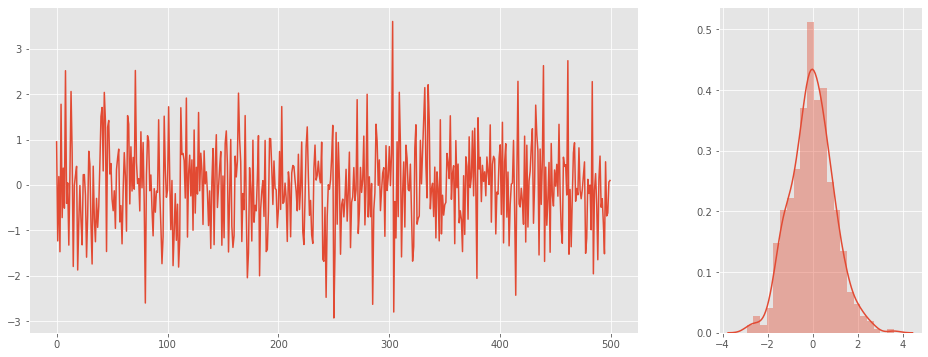

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy
from scipy import stats
import statsmodels.api as sm

plt.style.use('ggplot')

n = 500
fig, ax = plt.subplots(1,2, figsize=(16, 6), gridspec_kw={'width_ratios':[3, 1]})
eps = np.random.normal(size=n)
ax[0].plot(eps)
sns.distplot(eps, ax=ax[1])
plt.show()

---
### Step 2: AR Process

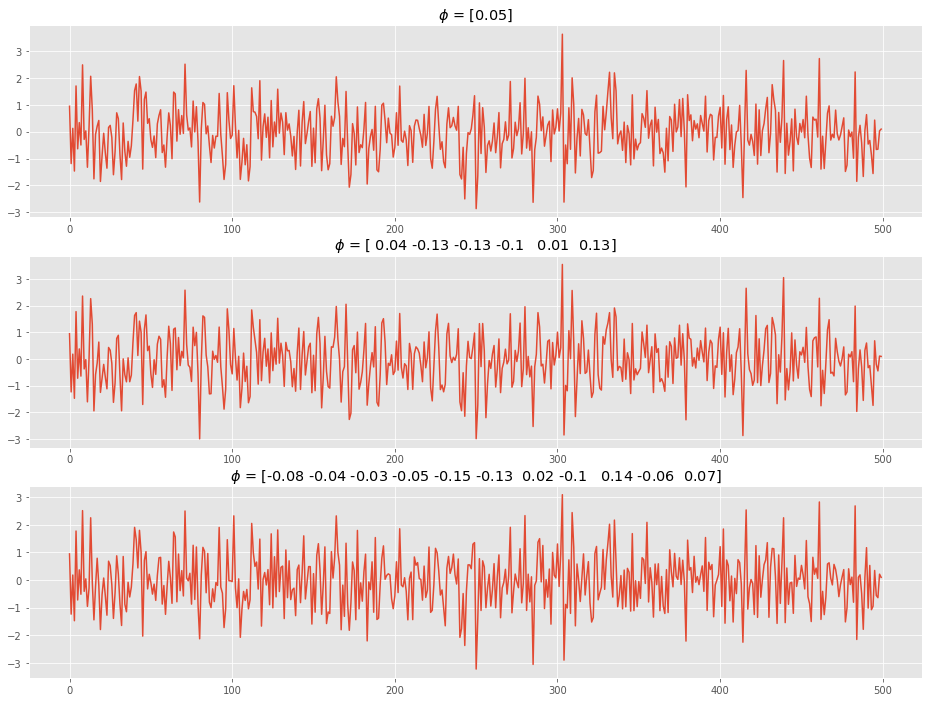

In [3]:
def ar_process(eps, phi):
    """
    Creates a AR(p) process with a zero mean. 
    eps: white noise signal
    phi: parameters of the process, p = len(phi)
    """
    phi = np.r_[1, phi][::-1] # Reverse the order of phi and add a 1 for current eps_t
    ar = eps.copy()
    offset = len(phi)
    for i in range(offset, ar.shape[0]):
        ar[i - 1] = ar[i - offset: i] @ phi
    return ar

fig = plt.figure(figsize=(16, 4 * 3))
a = 310
for i in range(0, 11, 5):
    a += 1
    phi = np.random.normal(0, 0.1, size=i + 1)
    plt.subplot(a)
    plt.title(f'$\\phi$ = {phi.round(2)}')
    plt.plot(ar_process(eps, phi))

---
### Step 3: MA Process

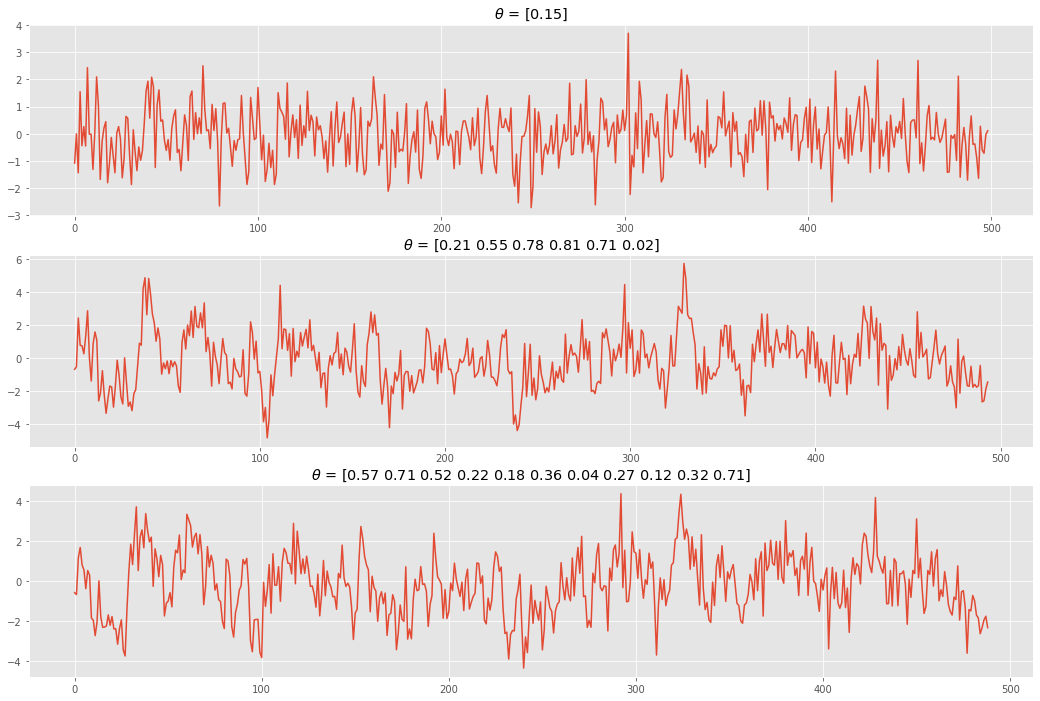

In [4]:
def ma_process(eps, theta):
    """
    Creates an MA(q) process with a zero mean.
    eps: white noise signal.
    theta: parameters of the process, q = len(theta)
    """
    return np.convolve(eps, [1] + list(theta), 'valid')

fig = plt.figure(figsize=(18, 4 * 3))
a = 310
for i in range(0, 11, 5):
    a += 1
    theta = np.random.uniform(0, 1, size = i + 1)
    plt.subplot(a)
    plt.title(f'$\\theta$ = {theta.round(2)}')
    plt.plot(ma_process(eps, theta))

---
## Step 4: Autocorrelation Function

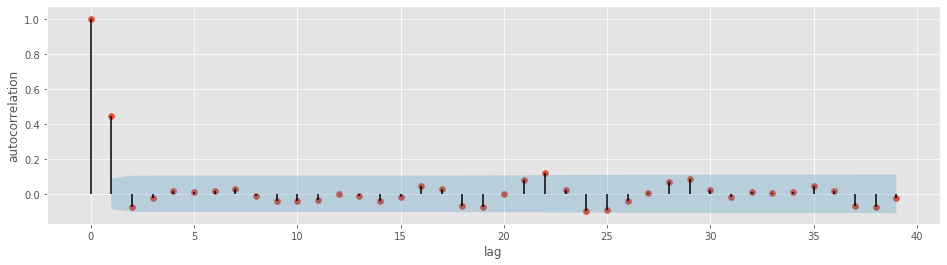

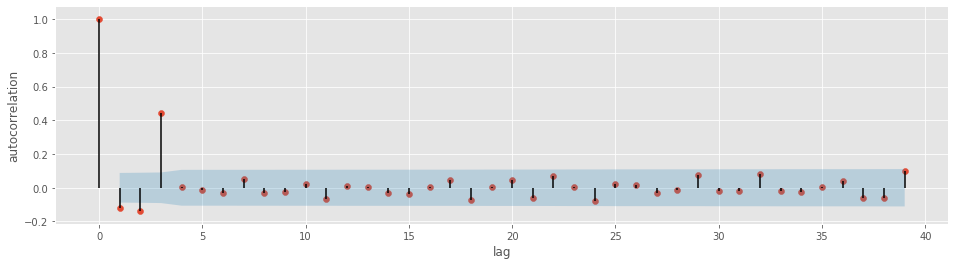

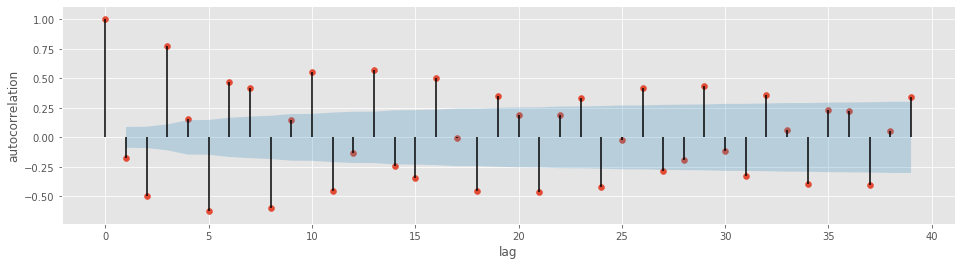

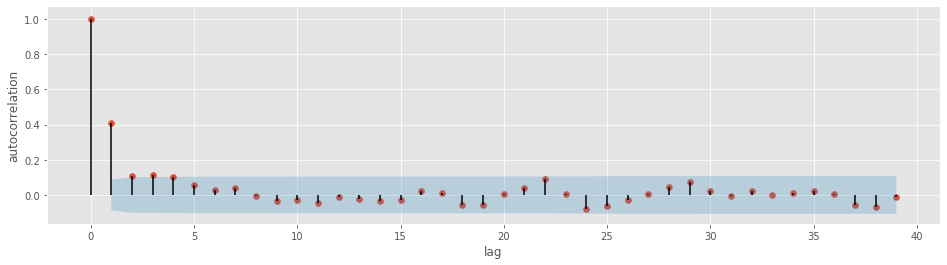

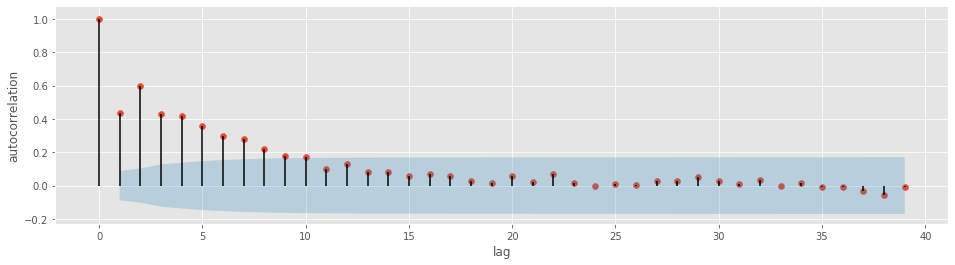

In [5]:
def pearson_correlation(x, y):
    return np.mean((x - x.mean()) * (y - y.mean())) / (x.std() * y.std())

def acf(x, lag=40):
    """
    Determine autocorrelation factors.
    x: time series
    lag: number of lags
    """
    return np.array([1] + [pearson_correlation(x[:-i], x[i:]) for i in range(1, lag)])

def bartletts_formula(acf_array, n):
    """
    Computes the Standard Error of an acf with Bartlet's formula
    See https://en.wikipedia.org/wiki/Correlogram
    acf_array: containing autocorrelation factors
    n: length of original time series sequence
    """
    # The first value has autocorrelation with it self. So that values is skipped
    se = np.zeros(len(acf_array) - 1)
    se[0] = 1 / np.sqrt(n)
    se[1:] = np.sqrt((1 + 2 * np.cumsum(acf_array[1:-1]**2)) / n )
    return se

def plot_correlation(x, func, alpha=0.05, lag=40):
    """
    x: time series
    alpha: statistical significance for confidence interval
    lag: number of lags
    """
    acf_val = func(x, lag)
    plt.figure(figsize=(16, 4))
    plt.vlines(np.arange(len(acf_val)), 0, acf_val)
    plt.scatter(np.arange(len(acf_val)), acf_val, marker='o')
    plt.xlabel('lag')
    plt.ylabel('autocorrelation')
    
    # Determine confidence interval
    ci = stats.norm.ppf(1 - alpha / 2.) * bartletts_formula(acf_val, len(x))
    plt.fill_between(np.arange(1, ci.shape[0] + 1), -ci, ci, alpha=0.25)

def plot_acf(x, alpha=0.05, lag=40):
    plot_correlation(x, acf, alpha, lag)

processes = [
    ma_process(eps, [1]),
    ma_process(eps, [0.2, -0.3, 0.8]),
    ar_process(eps, [0.2, -0.3, 0.8]),
    ar_process(eps, [0.5, -0.1, 0.1]),
    ar_process(eps, [0.2, 0.5, 0.1])
]

for p in processes:
    plot_acf(p)

---
## Step 5: Partial Autocorrelation

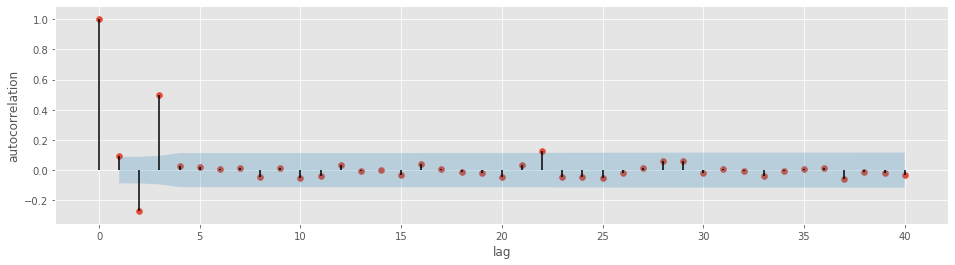

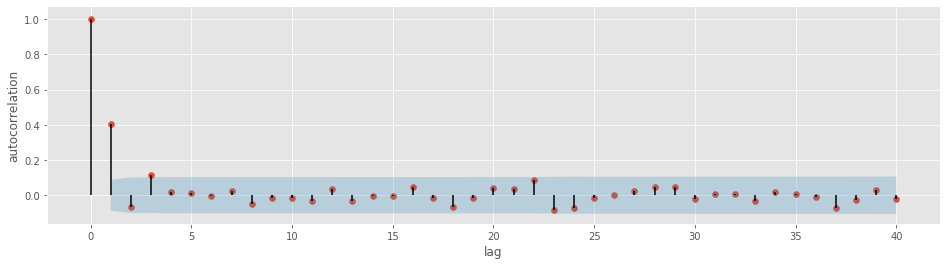

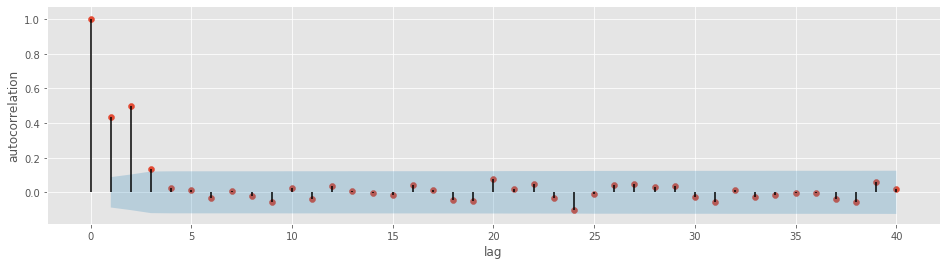

In [6]:
from sklearn.linear_model import LinearRegression

def lag_view(x, k):
    """
    returns an array where each x_i is replaced with its lags [x_i-1, x_i-2, ... x_i-k]
    """
    return np.array( [ x[i : i+k] for i in range(0, len(x)-k+1) ] )

def pacf(x, lag=40):
    """
    Partial autocorrelation function
    """
    y = [1, acf(x, 2)[1]]       # 1st and 2nd elments of PACF: PACF(0) = 1.0, PACF(1) = corr(x_t, x_t+1)
    for i in range(3, lag + 2): # compute 3rd element of PACF onwards
        lags = lag_view(x, i)
        xt = lags[:, 0]
        xt_lags = lags[:, 1:-1]
        # predict xt's based on xt_lags using linear regression
        xt_hat = LinearRegression(fit_intercept=False).fit(xt_lags, xt).predict(xt_lags) # explained part of x_t

        xt_k = lags[:, -1]
        # predict xt-k's based on xt_lags using linear regression
        xt_k_hat = LinearRegression(fit_intercept=False).fit(xt_lags, xt_k).predict(xt_lags) # explained part of x_t-k

        y.append(pearson_correlation(xt - xt_hat, xt_k - xt_k_hat)) # correlation of unexplained residuals
    
    return np.array(y)

def plot_pacf(x, alpha=0.05, lag=40, title=None):
    plot_correlation(x, pacf, alpha, lag)

plot_pacf(ar_process(eps, [0.3, -0.3, 0.5]))
plot_pacf(ar_process(eps, [0.5, -0.1, 0.1]))
plot_pacf(ar_process(eps, [0.2, 0.5, 0.1]))


---
## Step 6: ARIMA Model

In [7]:
def difference(x, d = 1):
    if d == 0:
        return x
    else:
        x = np.r_[x[0], np.diff(x)]
        return difference(x, d - 1)
    
def undo_difference(x, d = 1):
    if d == 1:
        return np.cumsum(x)
    else:
        x = np.cumsum(x)
        return undo_difference(x, d - 1)
    
class ARIMA():
    def __init__(self, q, d, p):
        self.p = p
        self.d = d
        self.q = q
        
    def prepare_features(self, x):
        if self.d > 0:
            x = difference(x, self.d)
        
        # AR process: features are lags
        ar_features = lag_view(np.r_[np.zeros(self.p), x], self.p)[:-1] # prepend with zero lags
        
        # MA process
        if self.q > 0:
            ar_model = LinearRegression().fit( ar_features, x )
            x_hat_ar = ar_model.predict(ar_features)
            residuals = x - x_hat_ar
            ma_features = lag_view(np.r_[np.zeros(self.q), residuals], self.q)[:-1] # prepend with zero lags
                                
        if self.p > 0 and self.q > 0:    # ARMA model 
            features = np.hstack((ar_features, ma_features))
        elif q > 0:                      # MA model
            features = ma_features
        else:                            # AR model
            features = ar_features
        
        return features
    
    def fit(self, x):
        features = self.prepare_features(x)
        self.model = LinearRegression().fit(features, x)
        return self
    
    def predict(self, x):
        features = self.prepare_features(x)
        y = self.model.predict(features)
        return self.return_output(y)
    
    def return_output(self, x):
        if self.d > 0:
            x = undo_difference(x, self.d) 
        return x
    
    def forecast(self, x, n):
        y = self.predict(x)
        
        y = np.r_[y, np.zeros(n)]
        for i in range(n):
            lags = np.r_[y[-(self.p + n) + i: -n + i], np.zeros(self.q)]
            y[x.shape[0] + i] = self.model.predict(lags[None, :])
        return self.return_output(y)

---
## Step 7: Fitting the ARIMA Model

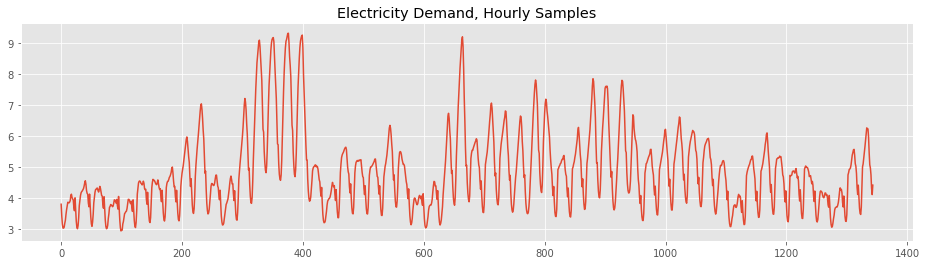

In [9]:
# loading a test dataset
import pandas as pd
data = pd.read_csv('../resources/time-series/electricity-demand-victoria.csv', comment='#', header=None).T
x = data[0].values.squeeze()

plt.figure(figsize=(16, 4))
plt.title('Electricity Demand, Hourly Samples')
plt.plot(x);

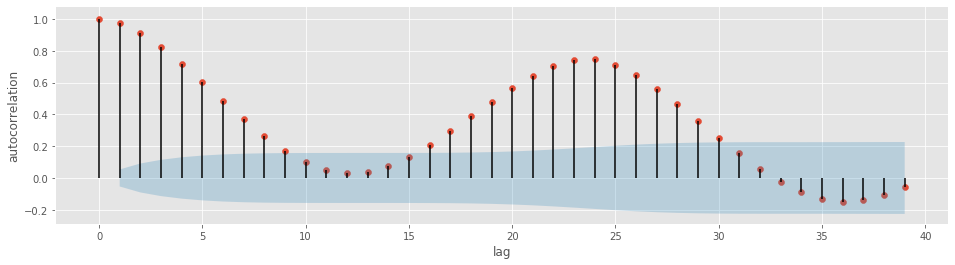

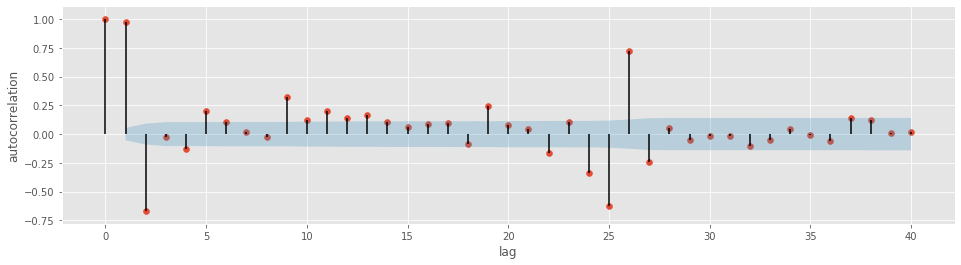

In [10]:
plot_acf(x)
plot_pacf(x)

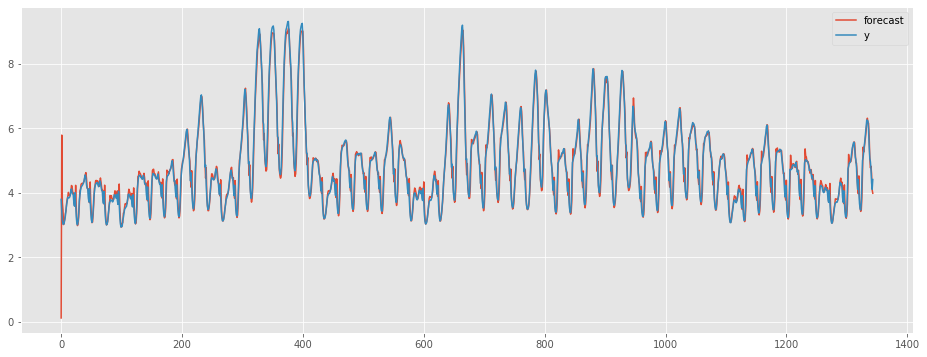

In [11]:
# fitting the model
q = 1
d = 0
p = 3

model = ARIMA(q = 1, d = 0, p = 3)
pred = model.fit(x).predict(x)

plt.figure(figsize=(16, 6))
ax = plt.subplot(111)
ax.plot(pred, label='forecast')
ax.plot(x, label='y')
plt.legend()

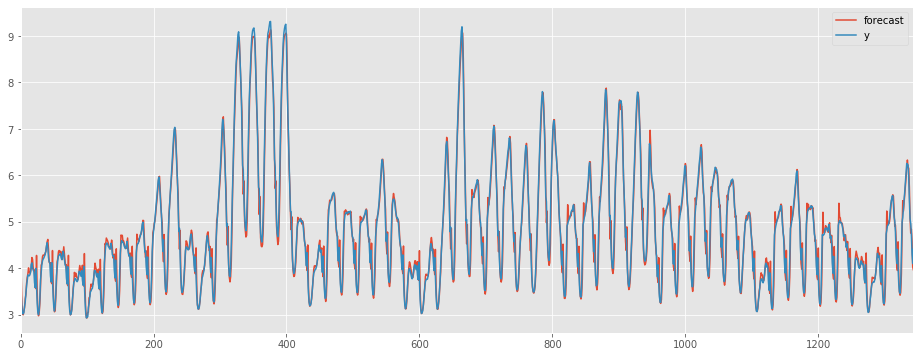

In [12]:
# compare with statsmodel implementation - similar but not exactly the same
results = sm.tsa.ARIMA(x, (p, d, q)).fit()
plt.figure(figsize=(16, 6))
ax = plt.subplot(111)
pred_sm = results.plot_predict(ax=ax)

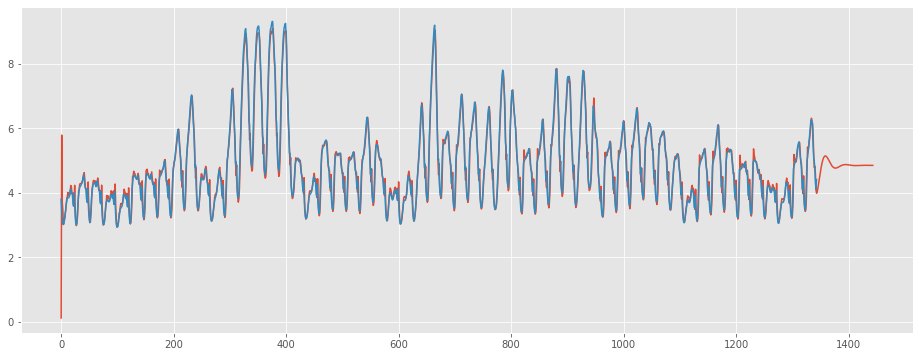

In [13]:
# forecasting
pred = model.forecast(x, 100)
plt.figure(figsize=(16, 6))
ax = plt.subplot(111)
ax.plot(pred)
ax.plot(x)